<a href="https://colab.research.google.com/gist/jonghank/9d318493a04ccad8da81f87eff2a6e55/trajectory_optmization_under_nonconvex_constraints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trajectory optimization under nonconvex constraints


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

---



We'll consider optimal vehicle guidance problem with position $p_t\in\R^2$, velocity $v_t\in\R^2$. The vehicle's control force $u_t\in\R^2$ is acceleration control for the two axes.

<br>

The dynamics is governed by 

$$
\begin{aligned}
  \dot{v} &= u - \gamma v  \\
  \dot{p} &= v  
\end{aligned}
$$

where a small constant $\gamma$ is the friction (or damping) coefficient. Trapezoidal integration assuming constant acceleration during the sampling interval gives following,

$$
\begin{aligned}
  v_{t+1} &= v_t + {\Delta t}\left( u_t - \gamma v_t  \right) \\
  &= \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  p_{t+1} &= p_t + 0.5{\Delta t}\left( v_t + v_{t+1} \right)  \\ 
  &= p_t + 0.5{\Delta t}\left( v_t + \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \right)  \\ 
  &= p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t
\end{aligned}
$$

and the minimum energy trajectory optimization problem can be formulated as follows.

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} 
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des} 
\end{aligned}
$$

<br>

We consider the finite horizon of $T=50$, and $\Delta t=0.1$, with the following data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 500 
T = 50 
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = .05 # damping

p_0   = np.array([ 10, -20])
v_0   = np.array([ 15,  -5])
p_des = np.array([100,  50])
v_des = np.array([  0,   0])

<br>

---

## Minimum energy control with state and control limits

Suppose your vehicle is subjecteed to move inside a rectangular area with limited maneuver acceleration. It is like your robot vaccum searching for the minimum energy trajectory inside your (rectangular) room. 

The constrained trajectory optimization problem can be described by

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} 
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des} \\
  & p_\text{lb} \le p_t \le p_\text{ub} \\
  & \| u_t \| \le u_\text{ub}
\end{aligned}
$$

where $p_\text{lb}$ and $p_\text{ub}$ describe the boundary of the rectangle and $u_\text{ub}$ is the upper bound of the maneuver acceleration.


In [2]:
import cvxpy as cp

###########################
p_lb = np.array([  0, -35])
p_ub = np.array([115,  70])
u_ub = 1.0
###########################

p = cp.Variable((2,N+1))  # p_{0},...,p_{N}
v = cp.Variable((2,N+1))  # v_{0},...,v_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t] 
                + 0.5*delt**2*u[:,t] ]
    ################################################
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]
    ################################################
    
cp.Problem(obj, constr).solve(verbose=True)

p_cp = np.array(p.value)
v_cp = np.array(p.value)
u_cp = np.array(u.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 29 10:00:41 AM: Your problem has 3004 variables, 2504 constraints, and 0 parameters.
(CVXPY) May 29 10:00:42 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 29 10:00:42 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 29 10:00:42 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 29 10:00:42 AM: Compiling problem (target solver=ECOS).
(CVXPY) May 29 10:00:42 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

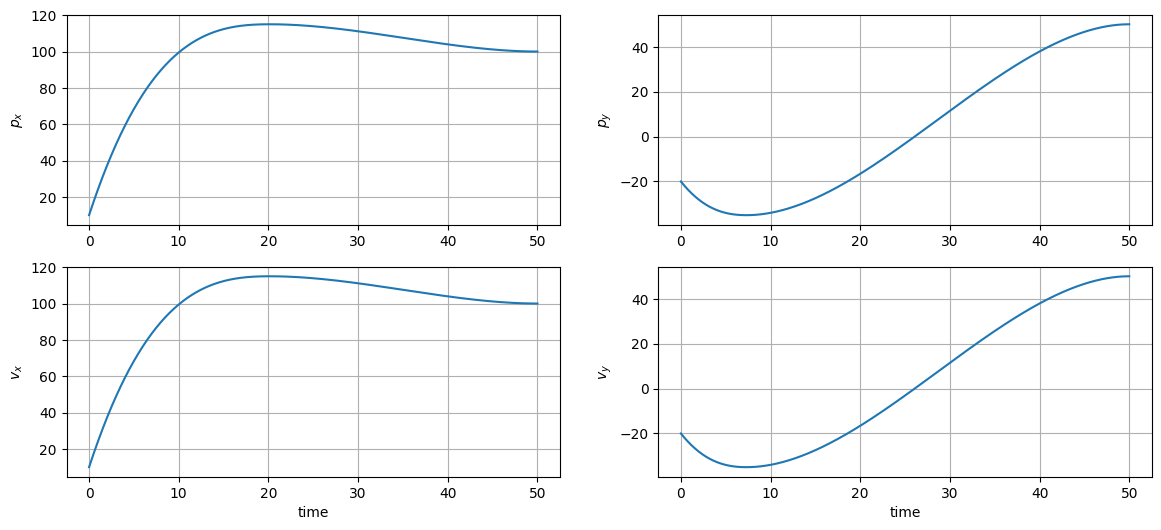

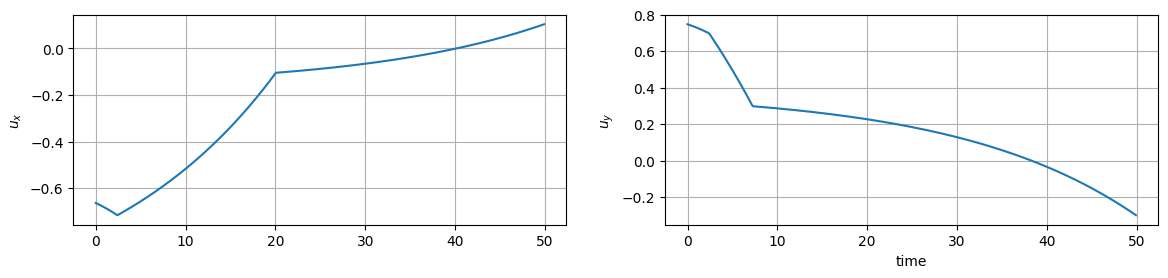

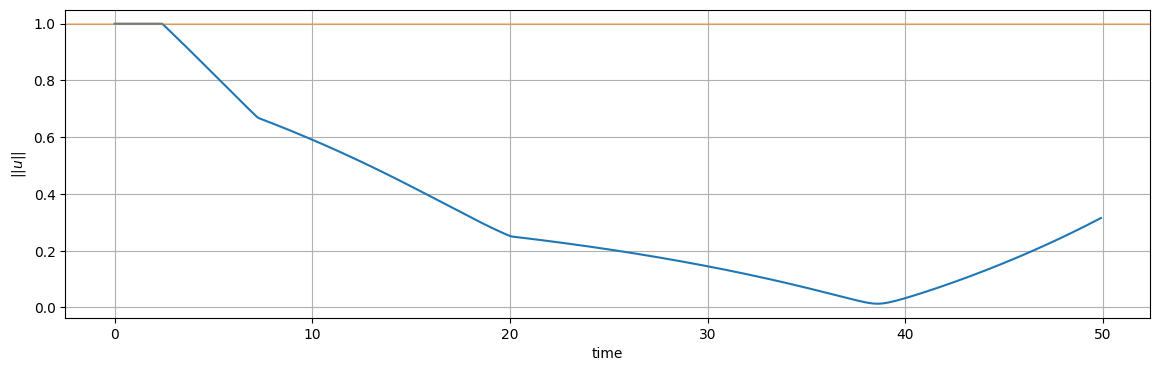

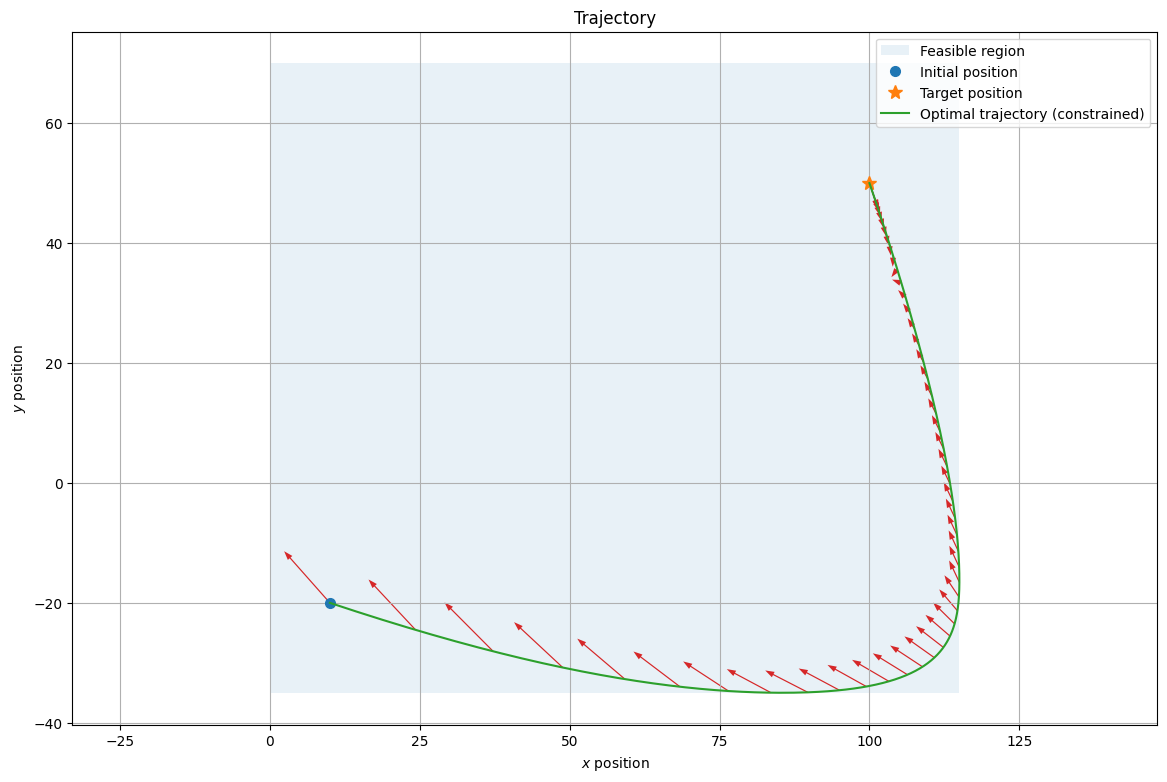

In [3]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,p_cp[0,:])
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,p_cp[1,:])
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,v_cp[0,:])
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,v_cp[1,:])
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_cp[0,:])
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_cp[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
plt.plot(ts[:-1],np.linalg.norm(u_cp,axis=0))
plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.4, label=r'$u_{ub}$')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.grid()
plt.show()
plt.show()

plt.figure(figsize=(14,9), dpi=100)
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')
plt.plot(p_cp[0,:],p_cp[1,:], label='Optimal trajectory (constrained)')
plt.title('Trajectory')
plt.legend()
for i in range(0,N-1,10):
  plt.arrow(p_cp[0,i], p_cp[1,i], 10*u_cp[0,i], 10*u_cp[1,i], \
            head_width=1.0, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br>

---

## Minimum energy control with nonconvex constraints

In addition to the previous constraints we add the following two nonconvex constraints:

* The trajectory should maintain the safety distance of $d_\text{sft}$ from the center $p_\text{obs}$.  
* The control should be always larger than $u_\text{lb}$ (some actuators require this).

So the problem can be described by

$$
\begin{aligned}
  \underset{u_t, v_t, p_t}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|_2^2  \\
  \text{subject to} 
  \quad & v_{t+1} = \left(1-\gamma \Delta t\right) v_t + \Delta t u_t \\
  \quad & p_{t+1} = p_t +  \left(\Delta t-0.5\gamma\Delta t^2\right) v_t + 0.5 \Delta t^2 u_t \\
  \quad & v_N = v_\text{des} \\
  \quad & p_N = p_\text{des} \\
  & p_\text{lb} \le p_t \le p_\text{ub} \\
  & \| p_t - p_\text{obs} \| \ge d_\text{sft} \\
  & u_\text{lb} \le \| u_t \| \le u_\text{ub}
\end{aligned}
$$

<br>

Note that the last two nonconvex constraints can be linearized along the reference trajectory $\bar{p}$ and $\bar{u}$ as follows.

\begin{equation}
\| p_t - p_\text{obs} \| \ge d_\text{sft} \quad \Longrightarrow \quad
2\left(\bar{p}_t - p_\text{obs}\right)^T p_t \ge d_\text{sft}^2 + \|\bar{p}_t\|^2 - \|{p_\text{obs}}\|^2
\end{equation}

\begin{equation}
\| u_t \| \ge u_\text{lb} \quad \Longrightarrow \quad
2\bar{u}_t^T u_t \ge u_\text{lb}^2 + \|\bar{u}_t\|^2
\end{equation}

<br>

The following sequential convex programming procedures can handle the above nonconvex problem.

1. Set $k=0$ and find the initial reference trajectory, $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$, for the problem _without_ the nonconvex constraints.

2. Linearize (or convexify) the nonconvex constraints along the previously obtained reference trajectory, $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$.

3. Find the reference trajectory, $\left( u^{(k+1)}, v^{(k+1)}, p^{(k+1)}\right)$, for the problem with the linearzed constraints obtained from 2.

4. Terminate if $\left( u^{(k+1)}, v^{(k+1)}, p^{(k+1)}\right)$ and $\left( u^{(k)}, v^{(k)}, p^{(k)}\right)$ are close enough. Otherwise, set $k=k+1$ and go to 2.

In [4]:
p_cp_hist = []
v_cp_hist = []
u_cp_hist = []        

p = cp.Variable((2,N+1))  # p_{0},...,p_{N}
v = cp.Variable((2,N+1))  # v_{0},...,v_{N}
u = cp.Variable((2,N))    # u_{0},...,u_{N-1}

obj = cp.Minimize(cp.sum_squares(u))

constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t] 
                + 0.5*delt**2*u[:,t] ]
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]

cp.Problem(obj, constr).solve(verbose=True)

p_cp = np.array(p.value)
v_cp = np.array(v.value)
u_cp = np.array(u.value)

p_cp_hist.append(p_cp)
v_cp_hist.append(v_cp)
u_cp_hist.append(u_cp)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 29 10:00:53 AM: Your problem has 3004 variables, 2504 constraints, and 0 parameters.
(CVXPY) May 29 10:00:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 29 10:00:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 29 10:00:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 29 10:00:54 AM: Compiling problem (target solver=ECOS).
(CVXPY) May 29 10:00:54 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

In [5]:
max_iters = 10

##########################
p_obs = np.array([120,20])
d_sft = 20
u_lb = 0.1
##########################

for iter in range(max_iters):

  p0 = p_cp
  v0 = v_cp
  u0 = u_cp

  obj = cp.Minimize(cp.sum_squares(u))

  constr  = [ p[:,-1] == p_des,  p[:,0] == p_0 ]
  constr += [ v[:,-1] == v_des,  v[:,0] == v_0 ]
  for t in range(N):
    constr += [ v[:,t+1] == (1-gamma*delt)*v[:,t] + delt*u[:,t] ]
    constr += [ p[:,t+1] == p[:,t] + delt*(1-0.5*gamma*delt)*v[:,t] 
                + 0.5*delt**2*u[:,t] ]
    constr += [ p_lb <= p[:,t+1], p[:,t+1] <= p_ub ]
    constr += [ cp.norm(u[:,t]) <= u_ub ]
    ##################################################################
    constr += [ 2*(p0[:,t] - p_obs).T@p[:,t] >= d_sft**2 
               + cp.sum_squares(p0[:,t]) - p_obs.dot(p_obs) ]
    constr += [ 2*u0[:,t].T@u[:,t] >= u_lb**2 + u0[:,t].dot(u0[:,t]) ]
    ##################################################################

  cp.Problem(obj, constr).solve(verbose=False)

  p_cp = p.value
  v_cp = v.value
  u_cp = u.value
       
  p_cp_hist.append(p_cp)
  v_cp_hist.append(v_cp)
  u_cp_hist.append(u_cp)

  print(iter)
  if (np.linalg.norm(p_cp_hist[-1]-p_cp_hist[-2],'fro')<1.0):
    n_iters = len(p_cp_hist)
    print(f'terminated after {iter+1} iterations')
    break


0
1
2
3
4
terminated after 5 iterations


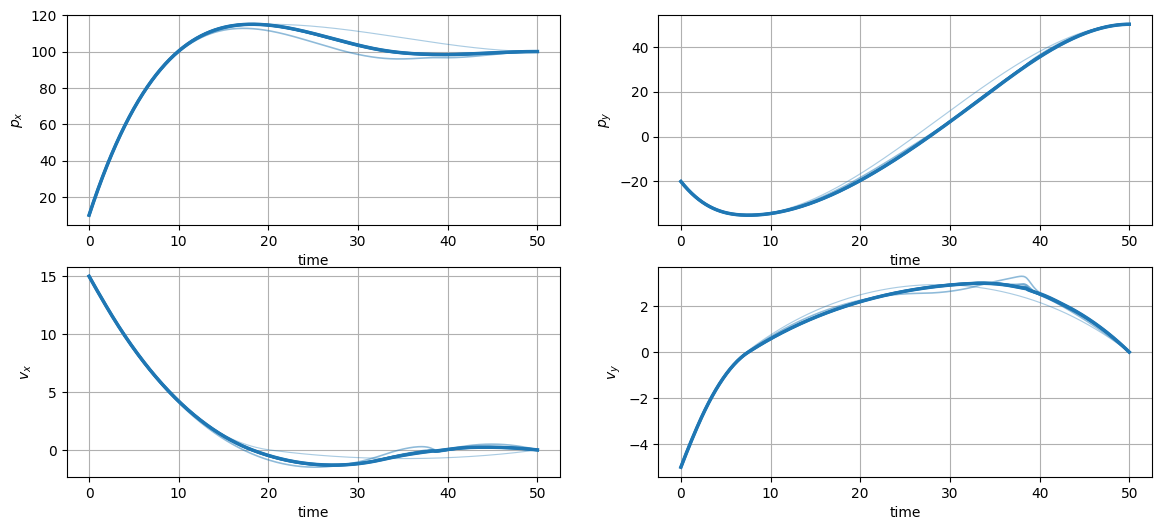

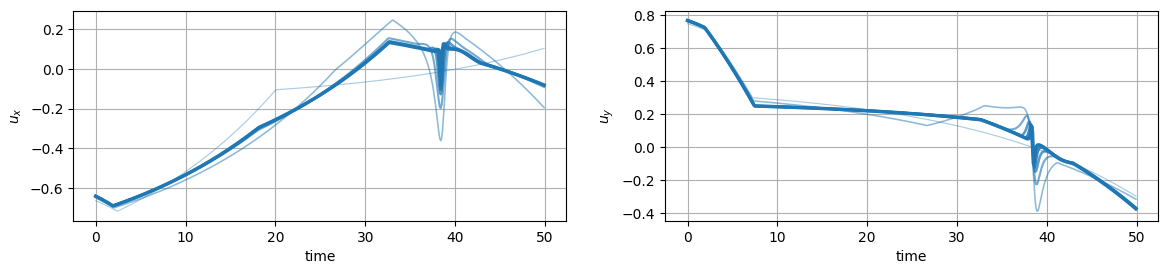

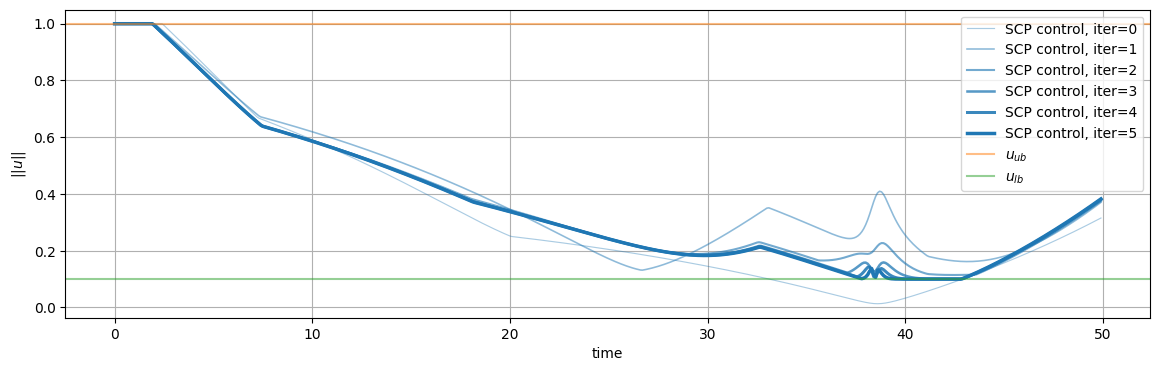

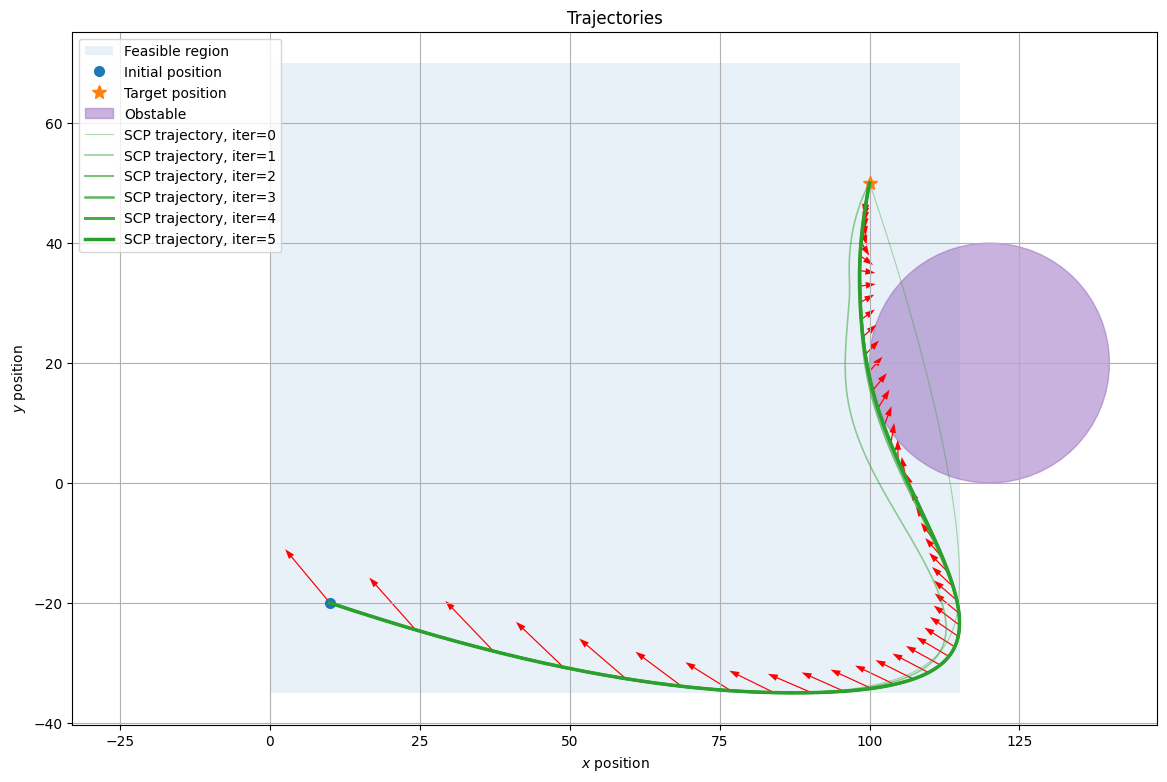

In [6]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts,p_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts,p_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$p_y$')
plt.grid()
plt.subplot(2,2,3)
for id in range(n_iters):
  plt.plot(ts,v_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_x$')
plt.grid()
plt.subplot(2,2,4)
for id in range(n_iters):
  plt.plot(ts,v_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$v_y$')
plt.grid()
plt.show()

plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
for id in range(n_iters):
  plt.plot(ts[:-1],u_cp_hist[id][0,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_x$')
plt.grid()
plt.subplot(2,2,2)
for id in range(n_iters):
  plt.plot(ts[:-1],u_cp_hist[id][1,:], color=plt.cm.tab20(0), \
           linewidth=0.5+(id+1)/n_iters*2, alpha = (id+1+2)/(n_iters+2))
plt.xlabel('time')
plt.ylabel(r'$u_y$')
plt.grid()
plt.show()
plt.figure(figsize=(14,4), dpi=100)
for id in range(n_iters):
  plt.plot(ts[:-1],np.linalg.norm(u_cp_hist[id],axis=0), \
           color=plt.cm.tab20(0), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP control, iter={id}')
plt.xlabel('time')
plt.ylabel(r'$||u||$')
plt.axhline(u_ub, color=plt.cm.tab20(2), alpha=0.5, label=r'$u_{ub}$')
plt.axhline(u_lb, color=plt.cm.tab20(4), alpha=0.5, label=r'$u_{lb}$')
plt.legend()
plt.grid()
plt.show()

axes = plt.figure(num=1, figsize=(14,9), dpi=100)
plt.broken_barh([(p_lb[0], p_ub[0])], (p_lb[1], p_ub[1]-p_lb[1]), \
                alpha = 0.1, label='Feasible region')
plt.plot(p_0[0], p_0[1], 'o', markersize=7, label='Initial position')
plt.plot(p_des[0], p_des[1], '*', markersize=10, label='Target position')
plt.gca().add_artist(plt.Circle((p_obs[0],p_obs[1]),d_sft, label='Obstable', \
                                color=plt.cm.tab20(8), alpha=0.5))
for id in range(n_iters):
  plt.plot(p_cp_hist[id][0,:], p_cp_hist[id][1,:], \
           color=plt.cm.tab20(4), linewidth=0.5+(id+1)/n_iters*2, \
           alpha = (id+1+2)/(n_iters+2), label=f'SCP trajectory, iter={id}')

plt.legend()
plt.title('Trajectories')

for t in range(0,N,10):
  plt.arrow(p_cp_hist[id][0,t], p_cp_hist[id][1,t], \
            10*u_cp_hist[id][0,t], 10*u_cp_hist[id][1,t], \
            head_width=1.1, width=0.2, color='r', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()